# Node2Vec Analysis

In this notebook, we are using the graph embeddings generated from `node2vec` to discover deeper insight from the graph created by `data/games/network_final/all_games.csv`.

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
homophily_embeddings = "../data/games/network_final/all_games_homophily.emb"
structural_equivalence_embeddings = "../data/games/network_final/all_games_structural_equivalence.emb"

homophily_df = pd.read_csv(homophily_embeddings, delimiter=" ", skiprows=1, index_col=0, header=None)
structural_equivalence_df = pd.read_csv(structural_equivalence_embeddings, delimiter=" ", skiprows=1, index_col=0, header=None)

In [69]:
homophily_df.rename(columns = {
    1: 'dim_1',
    2: 'dim_2',
    3: 'dim_3',
    4: 'dim_4',
    5: 'dim_5',
    6: 'dim_6',
    7: 'dim_7',
    8: 'dim_8',
    9: 'dim_9',
    10: 'dim_10',
    11: 'dim_11',
    12: 'dim_12',
    13: 'dim_13',
    14: 'dim_14',
    15: 'dim_15',
    16: 'dim_16',
}, inplace=True)
structural_equivalence_df.rename(columns = {
    1: 'dim_1',
    2: 'dim_2',
    3: 'dim_3',
    4: 'dim_4',
    5: 'dim_5',
    6: 'dim_6',
    7: 'dim_7',
    8: 'dim_8',
    9: 'dim_9',
    10: 'dim_10',
    11: 'dim_11',
    12: 'dim_12',
    13: 'dim_13',
    14: 'dim_14',
    15: 'dim_15',
    16: 'dim_16',
}, inplace=True)
structural_equivalence_df

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16
0,,,,,,,,,,,,,,,,
k6q4rqzd,0.560403,-0.674488,-0.108193,-0.165027,0.286138,0.495170,-0.156315,-0.647185,-0.484900,-0.507342,0.105681,-0.340377,-0.552731,0.275348,-0.108667,-0.029124
j1ne0vl1,0.750725,-0.729758,-0.355445,-0.267988,0.334830,0.597100,-0.299367,-0.720684,-0.535383,-0.315957,-0.171554,-0.299669,-0.657457,0.379738,-0.090404,-0.027035
j1ll47v1,1.032620,-0.426552,-0.414637,-0.186035,0.095312,0.600915,-0.170509,-0.582638,-0.653795,-0.385857,0.045058,-0.424756,-0.731465,0.563955,-0.004683,-0.047370
nd285r3d,0.648277,-1.088990,-0.206701,-0.309525,0.158356,0.505414,-0.651718,-0.787099,-0.174140,-0.305919,0.300207,-0.465048,-0.439391,0.647975,-0.102290,0.330708
3dx2j9y1,0.970359,-0.823714,-0.246662,0.187853,-0.004362,0.308902,-0.649781,-0.709778,-0.757962,-0.370247,-0.201757,-0.439204,-0.260259,0.217872,-0.403692,0.241191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m1zkgoz1,0.118181,-0.190548,0.000748,-0.003987,0.305530,0.205228,-0.132742,0.089351,-0.499924,-0.154719,0.363836,-0.192082,-0.214761,0.081185,-0.337073,-0.093375
o1y9pm26,-0.002626,-0.054731,-0.057321,-0.152357,0.323320,0.161691,-0.152764,0.176850,-0.513463,-0.003404,0.350548,-0.371418,-0.109778,0.044046,-0.428083,-0.151480
4d7nl3l6,0.117993,-0.236233,-0.032622,-0.117988,0.208169,0.199254,-0.112014,-0.057318,-0.361833,-0.093645,0.159115,-0.201276,-0.204471,0.076180,-0.271215,-0.080036


In [119]:
df = structural_equivalence_df.copy()

### Principal Component Analysis

(30433, 3)


Text(0, 0.5, 'pc2')

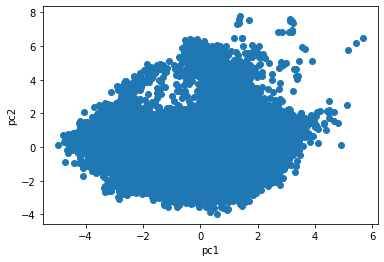

In [120]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

number_of_components = 3

scaled_df = StandardScaler().fit_transform(df)
pca = PCA(number_of_components)
transformed_df = pca.fit_transform(scaled_df)

print(transformed_df.shape)

plt.scatter(transformed_df[:,0],transformed_df[:,1],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

### K-Means Clustering

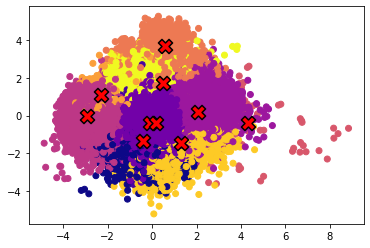

In [109]:
from sklearn.cluster import KMeans

number_of_clusters = 10

kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
kmeans.fit(scaled_df)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(transformed_df[:,0],transformed_df[:,1],c=labels,cmap='plasma')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)
plt.show()

### Hyper Parameter Tuning K-Means Clustering

Most of this subsection is taken from [here](https://github.com/Shivangi0503/Wine_Clustering_KMeans/blob/main/WineClustering.py).

In [121]:
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [122]:
parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]
parameter_grid = ParameterGrid({'n_clusters': parameters})
  
best_score = -1
kmeans_model = KMeans()
silhouette_scores = []

for p in parameter_grid:
    kmeans_model.set_params(**p)
    kmeans_model.fit(scaled_df)
    ss = metrics.silhouette_score(scaled_df, kmeans_model.labels_)
    silhouette_scores += [ss]
    if ss > best_score:
        best_score = ss
        best_grid = p

best_number_of_clusters = best_grid['n_clusters']
print(best_number_of_clusters)

3


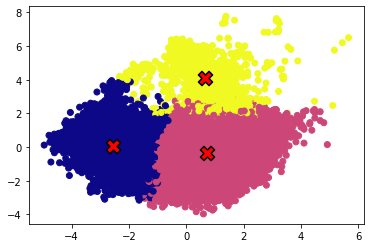

In [123]:
kmeans = KMeans(n_clusters=best_number_of_clusters, random_state=0)
kmeans.fit(scaled_df)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(transformed_df[:,0],transformed_df[:,1],c=labels,cmap='plasma')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)
plt.show()